<a href="https://colab.research.google.com/github/kiah-ucsd/DES200/blob/MiniProject/Mini_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project DSE 200: Starbucks Customer Data Analysis
#Part 1 - DEFINE
##Dataset Source
---
Dataset available on Kaggle: Starbucks Customer Data
https://www.kaggle.com/datasets/ihormuliar/starbucks-customer-data

##Business Context
---
Starbucks regularly sends out promotional offers to their customers through various channels (email, mobile, web, social media). These offers can be drink advertisements, discounts, or buy-one-get-one-free (BOGO) deals. Not all customers receive the same offer, and not all offers are equally effective. Understanding offer effectiveness and customer behavior can significantly impact business success.

##Project Objective
---
Analyze the Starbucks promotional offers dataset to derive actionable insights about customer behavior and offer effectiveness. Some potential areas to explore (but not limited to):

###Possible Analysis Directions
---
1. Offer Performance Analysis
- Which types of offers are most successful?
- How does offer success vary across different customer segments?
- What is the optimal duration for different types of offers?

2. Customer Segmentation
- Can we identify distinct customer groups based on their response to offers?
- How do demographics influence offer effectiveness?
- Which customer segments are most valuable to target?

3. Channel Effectiveness
- Which communication channels are most effective for different customer segments?
- Does multi-channel marketing improve offer success?

4. Customer Behavior Patterns
- What is the typical customer journey from receiving to completing an offer?
- Are there patterns in transaction behavior with and without offers?
- How does membership tenure relate to offer response?

##Technical Requirements
---
Your analysis should include:

1. Data Cleaning & Preprocessing
- Handle missing values
- Convert data types appropriately
- Create relevant features for analysis

2. Exploratory Data Analysis
- Visualize key patterns and relationships
- Identify significant trends
- Support findings with statistical analysis

3. Advanced Analytics (choose at least one)
- Customer Segmentation (e.g., clustering)
- Offer Success Prediction
- Customer Response Modeling
- Promotional Impact Analysis

4. Business Recommendations
- Clear, actionable insights
- Data-driven recommendations
- Potential impact assessment

## Deliverables
---
1. 5-minute presentation covering:
- Key insights discovered
- Methodology used
- Business recommendations
- Potential impact

2. Code submission including:
- Well-documented notebooks
- Clear explanation of analysis steps
- Visualizations and results

###Evaluation Criteria
---
- Quality of analysis and insights
- Technical implementation
- Clarity of presentation
- Business value of recommendations
- Creativity in approach

Remember: While these directions provide structure, feel free to explore additional aspects of the data that you find interesting or valuable. The goal is to demonstrate both technical skills and business acumen in analyzing real-world marketing data.

###Dataset Structure
---
The dataset consists of three main files:

1. portfolio.csv
Contains offer details with columns:

- id: Unique offer ID
- reward: Points given for offer completion
- channels: Marketing channels used (web, email, mobile, social)
- difficulty: Minimum spend required
- duration: Time period for offer
- offer_type: Type of offer (BOGO, discount, informational)

2. profile.csv
Customer demographic data with columns:

- id: Customer ID
- gender: Customer gender (M, F, O)
- age: Customer age (18-118)
- became_member_on: Account creation date
- income: Annual income (30k-120k)

3. transcript.csv
Transaction and offer interaction data with columns:

- id: Record ID
- person: Customer ID
- event: Type of record (transaction, offer received, offer viewed, etc.)
- value: Either offer ID or transaction amount
- time: Hours since start of data collection

##Project Goals
---
Create an analysis of the Starbucks customer data that includes:

1. Exploratory Data Analysis (EDA)
2. Data Preprocessing
3. Machine Learning
4. Analysis & Visualization
5. Business Insights

##Deliverables
---
1. 5-minute presentation of findings
2. Code submission for grading

##Project Requirements
---

Students should:
1. Fork the repository
2. Perform comprehensive data analysis
3. Present insights in a clear, concise manner
4. Submit code for evaluation

The project emphasizes practical application of data science techniques to gain meaningful business insights from real-world customer data.

#Part 2 - DISCOVER
###Step 2. Load Dataset---Check Head, info and describe , shape of dataset by query

In [ ]:
%pip install numpy pandas matplotlib seaborn scipy scikit-learn kagglehub

In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# Download latest version
path = kagglehub.dataset_download("ihormuliar/starbucks-customer-data")

print("Path to dataset files:", path)

# portfolio.csv
portfolio_df = pd.read_csv(path + "/portfolio.csv", index_col=0)

# profile.csv
profile_df = pd.read_csv(path + "/profile.csv", index_col=0)

# transcript.csv
transcript_df = pd.read_csv(path + "/transcript.csv", index_col=0)

100%|██████████| 7.38M/7.38M [00:00<00:00, 32.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ihormuliar/starbucks-customer-data/versions/1


# Portfolio

In [ ]:
portfolio_df.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [ ]:
print('\nProfile Info')
portfolio_df.info()
print('\nProfile Info')
portfolio_df.describe()


Profile Info
<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes

Profile Info


,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [ ]:
print('\nPortfolio Is Null Count\n')
portfolio_df.isnull().sum()


Portfolio Is Null Count



,0
reward,0
channels,0
difficulty,0
duration,0
offer_type,0
id,0


### Profile

---



In [ ]:
profile_df.head(2)

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [ ]:
print('\nProfile Info')
profile_df.info()
print('\nProfile Info')
profile_df.describe()


Profile Info
<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 796.9+ KB

Profile Info


,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [ ]:
print('\nProfile Is Null Count\n')
profile_df.isnull().sum()


Profile Is Null Count



,0
gender,2175
age,0
id,0
became_member_on,0
income,2175


In [ ]:
transcript_df.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [ ]:
print('\nTranscript Info')
transcript_df.info()

print('\nTranscript Describe')
transcript_df.describe()


Transcript Info
<class 'pandas.core.frame.DataFrame'>
Index: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 11.7+ MB

Transcript Describe


,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [ ]:
print('\nTranscript Is Null Count\n')
transcript_df.isnull().sum()


Transcript Is Null Count



,0
person,0
event,0
value,0
time,0


In [ ]:
profile_df.value_counts()

gender  age  id                                became_member_on  income 
O       100  9eb812054d564bdba180dc365f186e23  20160629          83000.0    1
F       18   0454292436bd4cee98e8ec873e30433e  20151030          62000.0    1
             13f95724ed4042aaa8953e8ed5d073c9  20151025          43000.0    1
             1d153ab70650433091710e2fb3146409  20170827          64000.0    1
             3769424ea9c84d198882174e8759614d  20180311          68000.0    1
                                                                           ..
             ef5fda2aa1f04f048a62637c22a959bd  20170223          73000.0    1
             eb695e77fdb84f359f7de63eabe6bc5f  20170911          31000.0    1
             e0749ba1296b41e9adbdc27c979b2510  20141127          40000.0    1
             df72761941ab427b9c8878508ad5814e  20131007          53000.0    1
             c1e96618c1e74fd192f8a5bb29b014f3  20170619          67000.0    1
Name: count, Length: 14825, dtype: int64

# Observations

## 1. General DataFrame Observations

### **Portfolio_df**
- No missing values.
- Defines offer details (`offer_type`, `reward`, `difficulty`, `duration`, `channels`).
- `id` column can be joined with **`transcript_df`** via the `offer_id` inside its `value` field.

---

### **Profile_df**
- Some missing values in `income` and `gender`.

**Data checks:**
- `.info()` confirmed:
  - `income` had nulls for a subset of customers.
  - `gender` also had missing entries.
- `.isnull().sum()` confirmed the same pattern numerically.
- `id` column can be joined with **`transcript_df`** via the `person` field.

---

### **Transcript_df**
- No missing values in core columns (`person`, `event`, `time`).
- `value` column contains nested data (e.g. `{'offer id': '...'}`) — will need to be unpacked.
- Can be joined with:
  - **`portfolio_df`** using `offer_id` from the `value` column.
  - **`profile_df`** using the `person` column.

---

## 2. Next Steps
1. Merge before cleaning using shared keys:
   - `offer_id` → links **transcript ↔ portfolio**
   - `person` → links **transcript ↔ profile**

2. Visualize to explore the data

3. Identify and classify the categorical data

4. Split into train / test

5. Clean and validate each individually:
   - Handle missing demographics in `profile_df`.
   - Parse the `value` column in `transcript_df`.

6. Once cleaned:
   - Feature creation (e.g. number of offers viewed, completed)
   - Exploratory analysis (conversion rates, demographics vs. response)

---


###Step 3. Merge Data


### List all the dataframes

In [ ]:
profile_df.head(1)
#print(len(profile_df))

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN


In [ ]:
portfolio_df.head(1)

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


In [ ]:
transcript_df.head(1)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


### Separate the value column

In [ ]:
import ast

# Convert to dict if needed
transcript_df['value'] = transcript_df['value'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Extract offer_id (handle both key styles)
transcript_df['offer_id'] = transcript_df['value'].apply(
    lambda x: (x.get('offer id') or x.get('offer_id')) if isinstance(x, dict) else None
)

# Extract reward
transcript_df['reward_earned'] = transcript_df['value'].apply(
    lambda x: x.get('reward') if isinstance(x, dict) else None
)

# Extract amount
transcript_df['amount'] = transcript_df['value'].apply(
    lambda x: x.get('amount') if isinstance(x, dict) else None
)


In [ ]:
transcript_df.head(1)

,person,event,value,time,offer_id,reward_earned,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN


### Find the columns to merge on
- profile['id'] <-->  transcript['person']

- portfolio[id] <--> transcript['offer_id']

In [ ]:
profile_len = profile_df.shape[0]
tanscript_len = transcript_df.shape[0]
portfolio_len = portfolio_df.shape[0]

print(f'Length of profile_df before merge {profile_len}\n Length of transcript before merge {tanscript_len} \n Length of portfolio before merge {portfolio_len}')

Length of profile_df before merge 17000
 Length of transcript before merge 306534 
 Length of portfolio before merge 10


In [ ]:
# Update the portfolio reward & id columns for clarity
portfolio_df = portfolio_df.rename(columns={'reward': 'reward_offer', 'id':'offer_id'})

#Update the profile id column for clarity
profile_id = profile_df.rename(columns={'id':'member_id'})



In [ ]:
# Perform first merge
events_with_profiles = pd.merge(profile_df,transcript_df, left_on='id', right_on='person',how='inner')
events_with_profiles.head(1)

,gender,age,id,became_member_on,income,person,event,value,time,offer_id,reward_earned,amount
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168,2906b810c7d4411798c6938adc9daaa5,NaN,NaN


In [ ]:
# Review the combined columns
events_with_profiles.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income', 'person', 'event',
       'value', 'time', 'offer_id', 'reward_earned', 'amount'],
      dtype='object')

In [ ]:
# sanity check that rows weren't lost
print(f'Length of new df after merge {events_with_profiles.shape[0]}')

Length of new df after merge 306534


In [ ]:
portfolio_df.head(1)

,reward_offer,channels,difficulty,duration,offer_type,offer_id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


In [ ]:
events_with_profiles.head(1)

,gender,age,id,became_member_on,income,person,event,value,time,offer_id,reward_earned,amount
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168,2906b810c7d4411798c6938adc9daaa5,NaN,NaN


In [ ]:
# Merge portfolio to the events with profiles
combined_events = pd.merge(events_with_profiles, portfolio_df, on = 'offer_id', how='left')
combined_events

,gender,age,id,became_member_on,income,person,event,value,time,offer_id,reward_earned,amount,reward_offer,channels,difficulty,duration,offer_type
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,"['web', 'email', 'mobile']",10.0,7.0,discount
1,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},216,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,"['web', 'email', 'mobile']",10.0,7.0,discount
2,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},336,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,5.0,"['web', 'email']",20.0,10.0,discount
3,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},348,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,5.0,"['web', 'email']",20.0,10.0,discount
4,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,transaction,{'amount': 0.35000000000000003},360,None,NaN,0.35,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,F,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,e4052622e5ba45a8b96b59aba68cf068,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,480,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,5.0,"['web', 'email', 'mobile', 'social']",5.0,5.0,bogo
306530,F,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,e4052622e5ba45a8b96b59aba68cf068,transaction,{'amount': 19.47},486,None,NaN,19.47,NaN,NaN,NaN,NaN,NaN
306531,F,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,e4052622e5ba45a8b96b59aba68cf068,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},546,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,"['web', 'email', 'mobile', 'social']",5.0,5.0,bogo
306532,F,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,e4052622e5ba45a8b96b59aba68cf068,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},576,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0.0,"['web', 'email', 'mobile']",0.0,4.0,informational


In [ ]:
print(f'Length of new df after merge {combined_events.shape[0]}')

Length of new df after merge 306534


In [ ]:
combined_events.head(2)

,gender,age,id,became_member_on,income,person,event,value,time,offer_id,reward_earned,amount,reward_offer,channels,difficulty,duration,offer_type
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,"['web', 'email', 'mobile']",10.0,7.0,discount
1,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},216,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,"['web', 'email', 'mobile']",10.0,7.0,discount


### Step 4: Explore the Data (EDA)
a. Layout the column counts / values

In [ ]:
# Loop through each dataframe
df = combined_events.copy()

numeric_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(exclude='number').columns

print("\nNumeric columns:", list(numeric_cols))
print("Categorical columns:", list(categorical_cols))

# Optional: show value counts for categorical columns
for col in categorical_cols:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts(dropna=False).head(5))


Numeric columns: ['age', 'became_member_on', 'income', 'time', 'reward_earned', 'amount', 'reward_offer', 'difficulty', 'duration']
Categorical columns: ['gender', 'id', 'person', 'event', 'value', 'offer_id', 'channels', 'offer_type']

Value counts for 'gender':
gender
M      155690
F      113101
NaN     33772
O        3971
Name: count, dtype: int64

Value counts for 'id':
id
94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
5e60c6aa3b834e44b822ea43a3efea26    48
d0a80415b84c4df4908b8403b19765e3    48
79d9d4f86aca4bed9290350fb43817c2    48
Name: count, dtype: int64

Value counts for 'person':
person
94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
5e60c6aa3b834e44b822ea43a3efea26    48
d0a80415b84c4df4908b8403b19765e3    48
79d9d4f86aca4bed9290350fb43817c2    48
Name: count, dtype: int64

Value counts for 'event':
event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name:

b. Visualize key patterns and relationships

Options:
- Offer Success Rate by Type: Bar chart of offer_type vs. completion rate
- Reward vs. Completion Rate: Scatter or line plot of reward_y vs. success
- Customer Demographics: Histograms of age, income
- Offer Completion by Gender: Grouped bar chart

In [ ]:
# Add completeda sucess flag
combined_events['offer_success'] = combined_events['event'].apply(lambda x: 1 if x== 'offer completed' else 0)

### Offer Success Rate by Type: Bar chart of offer_type vs. completion rate

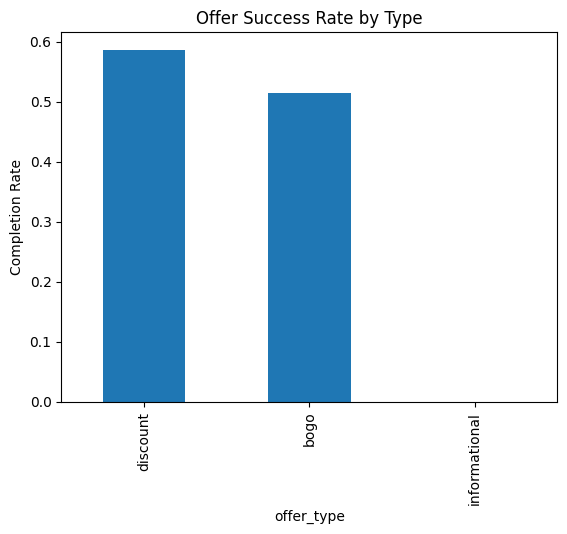

In [ ]:
# Filter by each event
received = combined_events[combined_events['event'] == 'offer received']
completed = combined_events[combined_events['event'] == 'offer completed']

# Count offers per type
offers_received = received.groupby('offer_type')['offer_id'].count()
offers_completed = completed.groupby('offer_type')['offer_id'].count()

# Calculate success rate
offer_success_rate = (offers_completed / offers_received).sort_values(ascending=False)

# Plot
offer_success_rate.plot(kind='bar', title='Offer Success Rate by Type', ylabel='Completion Rate')
plt.show()

Discounts drive the strongest engagement.
Customers complete discount offers most often, suggesting that straightforward savings motivate participation more effectively than “buy-one-get-one” or informational offers.

In [ ]:
combined_events.head(1)

,gender,age,id,became_member_on,income,person,event,value,time,offer_id,reward_earned,amount,reward_offer,channels,difficulty,duration,offer_type,offer_success
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,"['web', 'email', 'mobile']",10.0,7.0,discount,0


###Reward vs. Scaled Completion Rate, Difficulty, and Duration

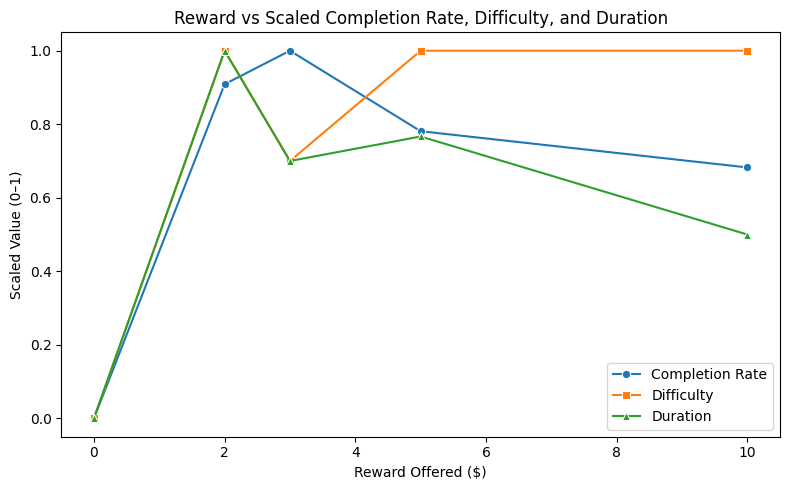

In [ ]:
# define the master x-axis (reward levels)
reward_levels = sorted(portfolio_df['reward_offer'].unique())

# 2) counts per reward (align indexes + fill)
received = combined_events[combined_events['event'] == 'offer received']
completed = combined_events[combined_events['event'] == 'offer completed']

rcv = received.groupby('reward_offer')['offer_id'].count().reindex(reward_levels, fill_value=0)
cmp = completed.groupby('reward_offer')['offer_id'].count().reindex(reward_levels, fill_value=0)

# 3) completion rate (handle div-by-zero -> 0)
success = (cmp / rcv).replace([np.inf, np.nan], 0).reset_index(name='success_rate')

# 4) avg difficulty per reward (from offer definitions to avoid duplication bias)
avg_diff = (portfolio_df
            .groupby('reward_offer')['difficulty']
            .mean()
            .reindex(reward_levels)
            .reset_index(name='avg_difficulty'))
avg_duration = (portfolio_df
                .groupby('reward_offer')['duration']
                .mean()
                .reindex(reward_levels)
                .reset_index(name='avg_duration')
                )

# 5) combine for plotting
plot_df = success.merge(avg_diff, on='reward_offer', how='left')

plot_df = plot_df.merge(avg_duration, on='reward_offer', how='left')

scaled = plot_df.copy()
scaler = MinMaxScaler()
scaled[['success_rate_scaled', 'avg_difficulty_scaled', 'avg_duration_scaled']] = scaler.fit_transform(
    plot_df[['success_rate', 'avg_difficulty', 'avg_duration']]
)

plt.figure(figsize=(8,5))
sns.lineplot(data=scaled, x='reward_offer', y='success_rate_scaled', label='Completion Rate', marker='o')
sns.lineplot(data=scaled, x='reward_offer', y='avg_difficulty_scaled', label='Difficulty', marker='s')
sns.lineplot(data=scaled, x='reward_offer', y='avg_duration_scaled', label='Duration', marker='^')
plt.title('Reward vs Scaled Completion Rate, Difficulty, and Duration')
plt.xlabel('Reward Offered ($)')
plt.ylabel('Scaled Value (0–1)')
plt.legend()
plt.tight_layout()
plt.show()

The $2 reward offer gives customers the longest time window and highest difficulty (Minimum required spend to complete an offer), yet it still has a strong completion rate (second-highest overall).

In [ ]:
combined_events.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income', 'person', 'event',
       'value', 'time', 'offer_id', 'reward_earned', 'amount', 'reward_offer',
       'channels', 'difficulty', 'duration', 'offer_type', 'offer_success'],
      dtype='object')

###Customer Demographics: Histograms of age, income

/tmp/ipython-input-2906194367.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['age_group', 'income_group'])


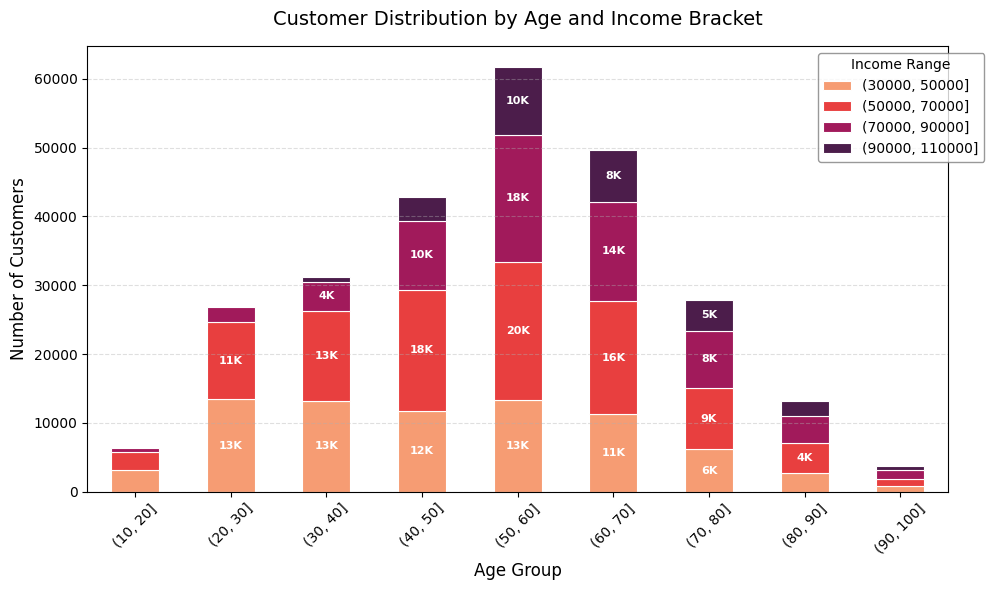

In [ ]:

# Visualizing Customer Distribution by Age and Income Bracket
combined_events['age_group'] = pd.cut(combined_events['age'], bins=range(10, 110, 10))
combined_events['income_group'] = pd.cut(combined_events['income'], bins=range(30000, 130000, 20000))

# Step 1: Aggregate customer counts by age and income groups
counts = (
    combined_events
    # Group the data by both age group and income group
    .groupby(['age_group', 'income_group'])
    # Count how many rows (customers) fall into each combination
    .size()
    # Pivot income_group into columns so each column represents an income range
    # Missing values are filled with 0 to avoid NaNs
    .unstack(fill_value=0)
)

# Step 2: Plot the grouped data as a stacked bar chart
ax = counts.plot(
    kind='bar',                              # bar chart
    stacked=True,                            # stack income brackets within each age group
    color=sns.color_palette("rocket_r",      # use a dark-to-light sequential palette
                            n_colors=len(counts.columns)),
    edgecolor='white',                       # add white borders for visual separation
    linewidth=0.8,                           # slight outline thickness
    figsize=(10,6)                           # figure size (width x height)
)

# Step 3: Add chart labels and style
plt.title('Customer Distribution by Age and Income Bracket', fontsize=14, pad=15)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)                      # rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.4) # add faint horizontal grid lines
plt.legend(
    title='Income Range',
    bbox_to_anchor=(1.05, 1),                # move legend outside the chart area
    frameon=True,
    facecolor='white',
    edgecolor='gray'
)

# Step 4: Annotate each stacked bar segment
# (optional but helps viewers see values directly instead of guessing)
for i, (index, row) in enumerate(counts.iterrows()):
    y_offset = 0                             # starting height at bottom of each bar
    for col in counts.columns:
        value = row[col]                     # number of customers in this income bracket
        if value > 4000:                     # only show labels if segment is large enough
            ax.text(
                i,                           # x-position (center of the bar)
                y_offset + value / 2,         # y-position (middle of the segment)
                f'{round(value/1000)}K',     # round to nearest thousand (e.g., 12K)
                ha='center', va='center',    # center alignment
                fontsize=8, color='white', fontweight='bold'
            )
        y_offset += value                    # increment height for next stacked layer

# Step 5: Adjust layout and show plot
plt.tight_layout()                           # prevent overlap of labels and edges
plt.show()


Most of our customers are in their 50s, typically earning $50k - $90k annually. This mid-career group forms the core of our community — people who are established, financially stable, and likely to respond well to thoughtful, value-driven offers.

In [ ]:
combined_events['event'].unique()
#combined_events.columns

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

Offer Completion by Gender

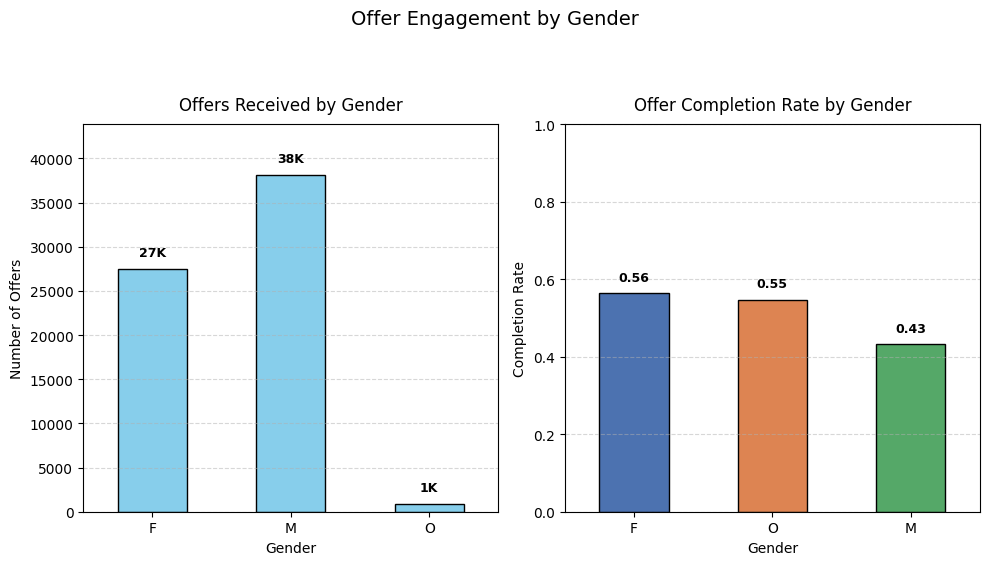

In [ ]:
# Filter by each event
received = combined_events[combined_events['event'] == 'offer received']
completed = combined_events[combined_events['event'] == 'offer completed']

# Count offers per gender
offers_received = received.groupby('gender')['offer_id'].count()
offers_completed = completed.groupby('gender')['offer_id'].count()

# Calculate success rate (completion / received)
offer_success_rate_by_gender = (offers_completed / offers_received).sort_values(ascending=False)

# Create 2 subplots (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(10,5.5))

# --- Chart 1: Offers Received ---
offers_received.plot(
    kind='bar',
    ax=axes[0],
    color='skyblue',
    edgecolor='black'
)
axes[0].set_title('Offers Received by Gender', fontsize=12, pad=10)
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Number of Offers')
axes[0].set_xticklabels(offers_received.index, rotation=0)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].set_ylim(0, offers_received.max() * 1.15)  # 15% headroom

# --- Chart 2: Offer Completion Rate ---
offer_success_rate_by_gender.plot(
    kind='bar',
    ax=axes[1],
    color=['#4C72B0', '#DD8452', '#55A868', '#8172B2'],
    edgecolor='black'
)
axes[1].set_title('Offer Completion Rate by Gender', fontsize=12, pad=10)
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Completion Rate')
axes[1].set_ylim(0, 1)
axes[1].set_xticklabels(offer_success_rate_by_gender.index, rotation=0)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Annotate left chart (Offers Received)
for i, val in enumerate(offers_received):
    # round to nearest thousand
    rounded_val = round(val, -3)
    label = f'{int(rounded_val/1000)}K'  # convert to 'K' notation
    axes[0].text(
        i, val + (0.03 * offers_received.max()),  # adds a bit of padding on top
        label,
        ha='center', va='bottom',
        fontsize=9, fontweight='bold'
    )

# Annotate right chart (Completion Rate)
for i, rate in enumerate(offer_success_rate_by_gender):
    axes[1].text(
        i, rate + 0.025,  # a bit of vertical spacing above the bar
        f'{rate:.2f}',
        ha='center', va='bottom',
        fontsize=9, fontweight='bold'
    )
plt.suptitle('Offer Engagement by Gender', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # ensures labels and titles aren’t cut off
plt.show()


Even though men get the most offers, they’re the least likely to complete them. Women, on the other hand, receive about a quarter fewer offers but finish them almost 15% more often — showing they’re a lot more engaged once they’re reached.

Summary Observations:
-

1. Offer Success Rate by Type:
Discount offers lead by a wide margin. Customers respond more consistently to simple, upfront savings compared to BOGO or informational offers.

2. Reward vs. Completion Rate, Difficulty, and Duration:
The $2 reward offer is an interesting outlier — it’s the hardest to complete and lasts the longest, yet it still has one of the highest success rates. That suggests people are willing to take on a challenge if the reward feels within reach.

3. Customer Demographics: Age and Income:
Most customers are in their 50s and typically earn between $50K–$90K a year. This mid-career segment likely values consistency and practical benefits, making them strong candidates for loyalty-driven or savings-based campaigns.

4. Offer Engagement by Gender:
Men receive the most offers but finish the fewest. Women, meanwhile, get fewer offers overall but complete them almost 15% more often — showing stronger engagement once they’re reached.


---


Takeaways

Overall, the data points to a few clear patterns:

1. Simple, value-focused offers (like discounts) perform best.

2. Mid-career adults form the core of the customer base, with high responsiveness to practical rewards.

3. Women tend to follow through more once they engage, hinting at an opportunity for tailored outreach.

###Encode Categorical Columns

Let's see the numeric and categorical columns

In [ ]:
def summarize_dataframe(df, name="DataFrame"):
    print(f"\n===== {name.upper()} SUMMARY =====")

    numeric_cols = df.select_dtypes(include='number').columns
    categorical_cols = df.select_dtypes(exclude='number').columns

    print("\nNumeric columns:", list(numeric_cols))
    print("Categorical columns:", list(categorical_cols))

    print("\n=== Numeric Summary ===")
    print(df[numeric_cols].describe().T)

    print("\n=== Categorical Value Counts ===")
    for col in categorical_cols:
        print(f"\nValue counts for '{col}':")
        print(df[col].value_counts(dropna=False).head(5))

summarize_dataframe(combined_events, name="Combined Events")




===== COMBINED EVENTS SUMMARY =====

Numeric columns: ['age', 'became_member_on', 'income', 'time', 'reward_earned', 'amount', 'reward_offer', 'difficulty', 'duration', 'offer_success']
Categorical columns: ['gender', 'id', 'person', 'event', 'value', 'offer_id', 'channels', 'offer_type', 'age_group', 'income_group']

=== Numeric Summary ===
                     count          mean           std          min  \
age               306534.0  6.090937e+01     26.032030        18.00   
became_member_on  306534.0  2.016545e+07  11904.602795  20130729.00   
income            272762.0  6.433700e+04  21243.762941     30000.00   
time              306534.0  3.663829e+02    200.326314         0.00   
reward_earned      33579.0  4.904137e+00      2.886647         2.00   
amount            138953.0  1.277736e+01     30.250529         0.05   
reward_offer      167581.0  4.419910e+00      3.373360         0.00   
difficulty        167581.0  7.850401e+00      5.048944         0.00   
duration        

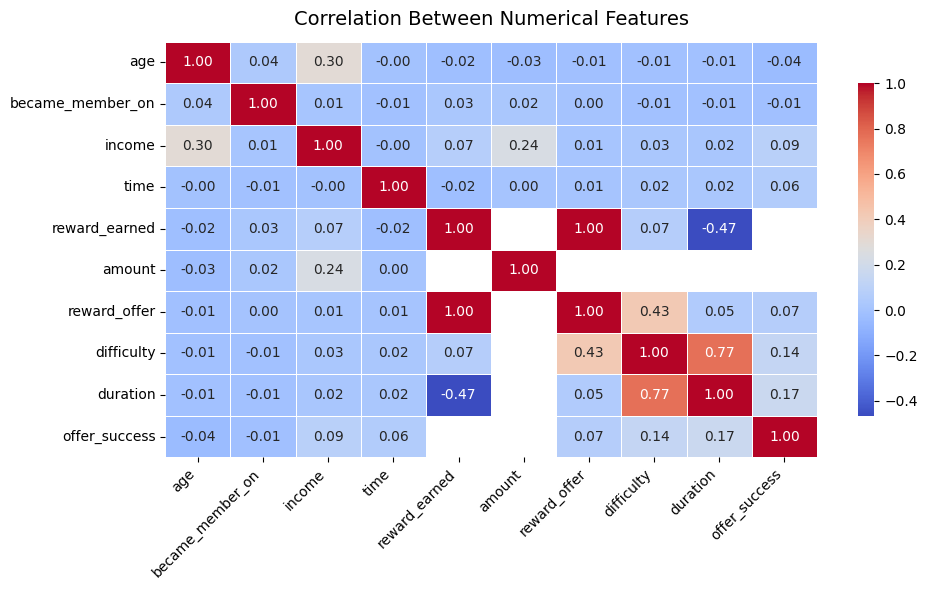

In [ ]:
#Plot a heatmap and look at the corelation

# Select only numerical features for correlation analysis
numerical_features = combined_events.select_dtypes(include=['number']).columns
numerical_df = combined_events[numerical_features]

#Plot a heatmap and look at the corelation
plt.figure(figsize=(10,6))  # Make the plot wider
sns.heatmap(
    numerical_df.corr(),
    cmap='coolwarm',
    annot=True,
    fmt=".2f",        # Limit decimal places to 2
    linewidths=0.5,   # Adds separation lines between boxes
    cbar_kws={"shrink": 0.8}  # Smaller color bar
)
plt.title('Correlation Between Numerical Features', fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Offers that are harder (require more spending) also tend to last longer. But let's check for multicollinearity (where two variables that basically say the same thing, so our model can’t tell which one is actually responsible for changes in the target) to be safe. We use Variance Inflation Factor (VIF) to check.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = numerical_df[['reward_offer', 'difficulty', 'duration']].dropna()
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data


,feature,VIF
0,reward_offer,2.899460
1,difficulty,8.653058
2,duration,7.251025


Since it's under 10 not a significant issue. Now let's encode the categorical columns.

In [ ]:

def encode_combined_events_ml(df):
    df = df.copy()

    # --- Step 1: Convert categoricals to strings + handle missing values ---
    cat_cols = ['gender', 'event', 'channels', 'offer_type', 'age_group', 'income_group']
    df[['age_group', 'income_group']] = df[['age_group', 'income_group']].astype(object)
    for col in cat_cols:
        if col in df.columns:
            # convert to string type first to avoid Category assignment error
            df[col] = df[col].fillna('Unknown').astype(str)

    # --- Step 2: Flatten list-like columns ---
    if 'channels' in df.columns:
        df['channels'] = df['channels'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

    # --- Step 3: Ordinal encode age/income groups ---
    if 'age_group' in df.columns:
        age_order = ['(30.0, 40.0]', '(40.0, 50.0]', '(50.0, 60.0]', '(60.0, 70.0]', 'Unknown']
        df['age_group'] = pd.Categorical(df['age_group'], categories=age_order, ordered=True).codes

    if 'income_group' in df.columns:
        income_order = ['(30000.0, 50000.0]', '(50000.0, 70000.0]',
                        '(70000.0, 90000.0]', '(90000.0, 110000.0]', 'Unknown']
        df['income_group'] = pd.Categorical(df['income_group'], categories=income_order, ordered=True).codes

    # --- Step 4: One-Hot Encode nominal columns ---
    nominal_cols = [col for col in ['gender', 'event', 'channels', 'offer_type'] if col in df.columns]
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ct = ColumnTransformer(transformers=[('onehot', ohe, nominal_cols)], remainder='passthrough')

    encoded_array = ct.fit_transform(df)
    encoded_cols = [c.replace('onehot__', '') for c in ct.get_feature_names_out()]
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols)
    encoded_df = encoded_df.apply(pd.to_numeric, errors='ignore')

    # --- Step 5: Drop identifier columns ---
    drop_cols = [c for c in encoded_df.columns if any(k in c for k in ['id', 'person', 'offer_id', 'value'])]
    encoded_df = encoded_df.drop(columns=drop_cols, errors='ignore')

    return encoded_df, ct

encoded_df, encoder = encode_combined_events_ml(combined_events)
encoded_df.columns = encoded_df.columns.str.replace("_Unknown", "_missing", regex=False)
encoded_df.info()


/tmp/ipython-input-2330476214.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  encoded_df = encoded_df.apply(pd.to_numeric, errors='ignore')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 29 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   gender_F                                       306534 non-null  float64
 1   gender_M                                       306534 non-null  float64
 2   gender_O                                       306534 non-null  float64
 3   gender_missing                                 306534 non-null  float64
 4   event_offer completed                          306534 non-null  float64
 5   event_offer received                           306534 non-null  float64
 6   event_offer viewed                             306534 non-null  float64
 7   event_transaction                              306534 non-null  float64
 8   channels_missing                               306534 non-null  float64
 9   channels_['email', 'mobile', 'social'

In [ ]:
encoded_df.head()
encoded_df.select_dtypes(include='number').shape[1] == encoded_df.shape[1]

True

Now we have all the columns in float64 or int64.Let's check the correlation.

Values close to +1 indicate a strong positive relationship (feature increases with success),
values close to –1 indicate a strong negative relationship (feature decreases with success).

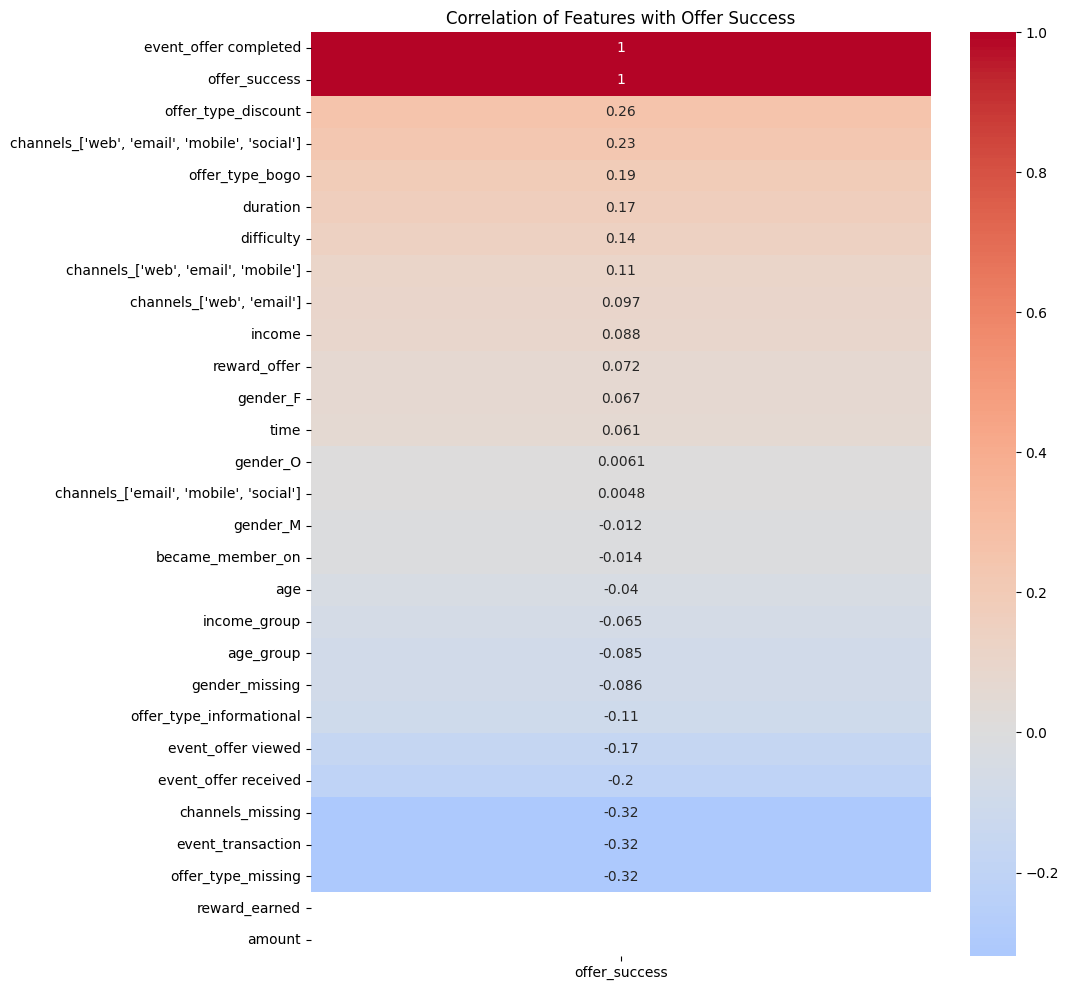

In [ ]:
# Optional cleanup for readability
encoded_df.columns = encoded_df.columns.str.replace('remainder__', '', regex=False)

plt.figure(figsize=(10, 12))

# Compute correlations
corr = encoded_df.corr()

# Plot only correlation with offer_success
sns.heatmap(
    corr[['offer_success']].sort_values(by='offer_success', ascending=False),
    annot=True, cmap='coolwarm', center=0
)

plt.title("Correlation of Features with Offer Success")
plt.show()


The type of offer and marketing channels used are the most influential predictors of offer success, while demographics (age, gender, income) contribute very little in this dataset.
This implies the campaign strategy — not user traits — is driving engagement.

channels_missing
event_transaction
offer_type_missing

Now that we finished encoding the categorical columns we'll move on to splitting the data.

### Split into train | test data

In [ ]:

leak_cols = [
    'reward_earned',
    'offer_success',
    'event_offer completed',  # direct indicator
    'event_offer viewed',     # occurs after receive, before complete — often leaks
    'event_transaction'       # activity may imply completion indirectly
]


y = encoded_df['offer_success']
X = encoded_df.drop(columns=[c for c in leak_cols if c in encoded_df.columns], errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
X.columns

Index(['gender_F', 'gender_M', 'gender_O', 'gender_missing',
       'event_offer received', 'channels_missing',
       'channels_['email', 'mobile', 'social']',
       'channels_['web', 'email', 'mobile', 'social']',
       'channels_['web', 'email', 'mobile']', 'channels_['web', 'email']',
       'offer_type_missing', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'age', 'became_member_on', 'income', 'time',
       'amount', 'reward_offer', 'difficulty', 'duration', 'age_group',
       'income_group'],
      dtype='object')

Identify which columns are missing data.

In [ ]:
encoded_df.isnull().sum()

,0
gender_F,0
gender_M,0
gender_O,0
gender_missing,0
event_offer completed,0
event_offer received,0
event_offer viewed,0
event_transaction,0
channels_missing,0
"channels_['email', 'mobile', 'social']",0


The strategy for these columns missing values are the following:
cols_zero_fill = ['reward_earned', 'amount', 'reward_offer', 'difficulty', 'duration']
cols_median_fill = ['income']

In [ ]:
cols_zero_fill = ['reward_earned', 'amount', 'reward_offer', 'difficulty', 'duration']
cols_median_fill = ['income']

# Make copies to avoid modifying originals
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

# Fill 0-based columns
for col in cols_zero_fill:
    if col in X_train_clean.columns:
        X_train_clean[col] = X_train_clean[col].fillna(0)
        X_test_clean[col] = X_test_clean[col].fillna(0)

# Fill median-based columns (fit medians from training data)
for col in cols_median_fill:
    if col in X_train_clean.columns:
        median_value = X_train_clean[col].median()
        X_train_clean[col] = X_train_clean[col].fillna(median_value)
        X_test_clean[col] = X_test_clean[col].fillna(median_value)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
model = LogisticRegression(max_iter=1000)
model.fit(X_train_clean, y_train)

print("Feature Importance:")
importance = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False)
print(importance.head(10))

print("\nTest Performance:")
print(classification_report(y_test, model.predict(X_test_clean)))


Feature Importance:
difficulty                                       0.100799
duration                                         0.076894
reward_offer                                     0.050369
offer_type_discount                              0.006430
channels_['web', 'email', 'mobile', 'social']    0.006123
offer_type_bogo                                  0.004904
channels_['web', 'email', 'mobile']              0.002401
time                                             0.001499
gender_F                                         0.001473
channels_['web', 'email']                        0.000982
dtype: float64

Test Performance:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     54591
           1       0.35      0.06      0.10      6716

    accuracy                           0.88     61307
   macro avg       0.62      0.52      0.52     61307
weighted avg       0.84      0.88      0.85     61307



Let's add in balanced to try to improve the 1 precision and recall score.

In [ ]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_clean, y_train)

print("Feature Importance:")
importance = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False)
print(importance.head(10))

print("\nTest Performance:")
print(classification_report(y_test, model.predict(X_test_clean)))


Feature Importance:
difficulty                                       0.141008
duration                                         0.108302
reward_offer                                     0.070819
offer_type_discount                              0.009013
channels_['web', 'email', 'mobile', 'social']    0.008751
offer_type_bogo                                  0.006934
channels_['web', 'email', 'mobile']              0.003363
gender_F                                         0.002004
time                                             0.001379
channels_['web', 'email']                        0.001331
dtype: float64

Test Performance:
              precision    recall  f1-score   support

           0       0.98      0.67      0.80     54591
           1       0.25      0.89      0.39      6716

    accuracy                           0.70     61307
   macro avg       0.62      0.78      0.60     61307
weighted avg       0.90      0.70      0.75     61307



Significant jump in recall and f1 score. Let's check AUC.

AUC: 0.8279423219977409


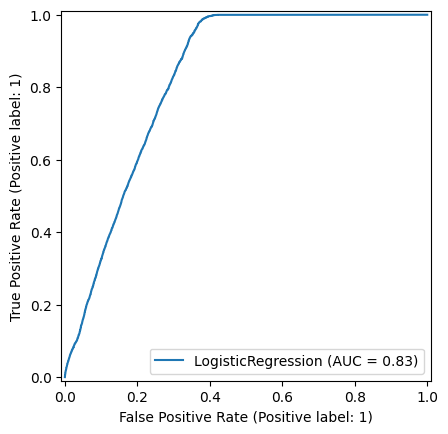

In [ ]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_test_clean, y_test)
print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test_clean)[:,1]))

An AUC of 0.83 is excellent for a marketing or behavioral prediction task — it means the model ranks a random successful offer higher than a random unsuccessful one 83% of the time.

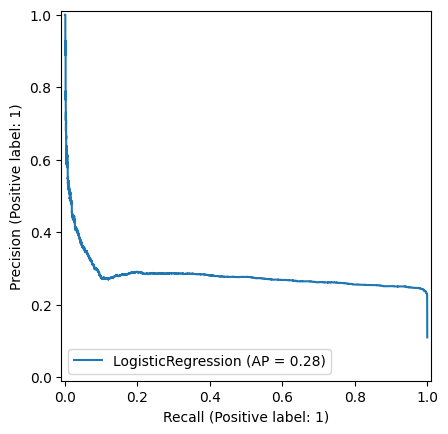

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(model, X_test_clean, y_test)
plt.show()

In [ ]:
y_probs = model.predict_proba(X_test_clean)[:, 1]
for t in [0.3, 0.4, 0.5, 0.6]:
    y_pred_t = (y_probs >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_test, y_pred_t))



Threshold = 0.3
              precision    recall  f1-score   support

           0       1.00      0.60      0.75     54591
           1       0.23      1.00      0.38      6716

    accuracy                           0.64     61307
   macro avg       0.62      0.80      0.56     61307
weighted avg       0.92      0.64      0.71     61307


Threshold = 0.4
              precision    recall  f1-score   support

           0       1.00      0.63      0.77     54591
           1       0.25      0.98      0.39      6716

    accuracy                           0.67     61307
   macro avg       0.62      0.80      0.58     61307
weighted avg       0.91      0.67      0.73     61307


Threshold = 0.5
              precision    recall  f1-score   support

           0       0.98      0.67      0.80     54591
           1       0.25      0.89      0.39      6716

    accuracy                           0.70     61307
   macro avg       0.62      0.78      0.60     61307
weighted avg       0.90

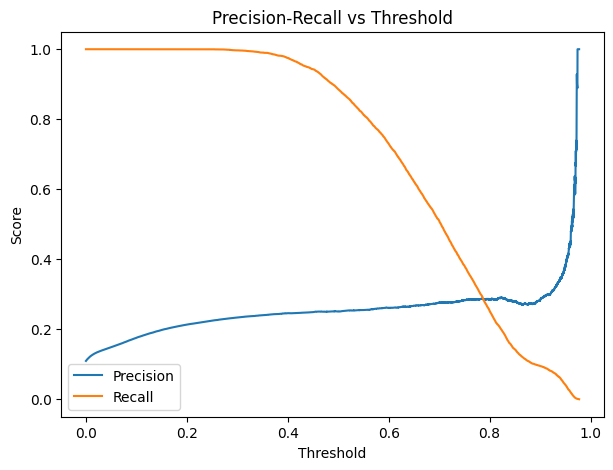

In [ ]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresh = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(7,5))
plt.plot(thresh, prec[:-1], label='Precision')
plt.plot(thresh, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.show()


We'll now give random forest a try

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    max_depth=10
)
rf.fit(X_train_clean, y_train)

y_pred_rf = rf.predict(X_test_clean)
y_probs_rf = rf.predict_proba(X_test_clean)[:, 1]

print("AUC:", roc_auc_score(y_test, y_probs_rf))
print(classification_report(y_test, y_pred_rf))


AUC: 0.9438314247825421
              precision    recall  f1-score   support

           0       1.00      0.84      0.92     54591
           1       0.44      0.99      0.61      6716

    accuracy                           0.86     61307
   macro avg       0.72      0.92      0.76     61307
weighted avg       0.94      0.86      0.88     61307



In [ ]:
importances = pd.Series(rf.feature_importances_, index=X_train_clean.columns)
print(importances.sort_values(ascending=False).head(10))


event_offer received                             0.296608
duration                                         0.152499
difficulty                                       0.145261
reward_offer                                     0.116544
amount                                           0.063270
channels_missing                                 0.054005
offer_type_missing                               0.049622
time                                             0.030847
offer_type_discount                              0.016329
channels_['web', 'email', 'mobile', 'social']    0.013045
dtype: float64


Key takeaway: Offer-related variables (duration, difficulty, reward) dominate customer/demographic ones.

In other words:
Offer design and structure are more predictive of success than demographic or behavioral segmentation alone.

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_train_clean, y_train, cv=5, scoring='roc_auc')
print(scores.mean(), scores.std())


0.9453857132145286 0.0005160606002035876


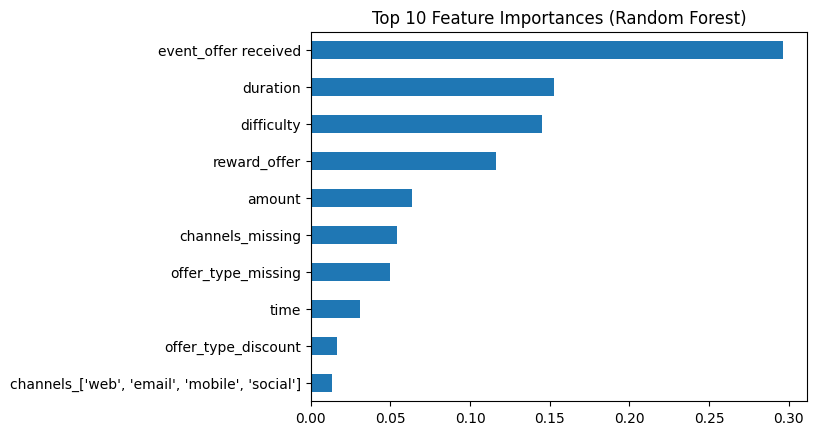

In [ ]:
importances.sort_values(ascending=True).tail(10).plot(kind='barh')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve
prec, rec, thresh = precision_recall_curve(y_test, y_probs_rf)
f1 = 2*(prec*rec)/(prec+rec)
best_t = thresh[np.argmax(f1)]
print(f"Best threshold: {best_t:.2f}")


Best threshold: 0.94


/tmp/ipython-input-2154886000.py:3: RuntimeWarning: invalid value encountered in divide
  f1 = 2*(prec*rec)/(prec+rec)


Lastly we'll try XgBoost

In [ ]:
# Clean up column names for XGBoost
X_train_xgb = X_train_clean.copy()
X_test_xgb = X_test_clean.copy()

# Replace bad characters
X_train_xgb.columns = (
    X_train_xgb.columns
    .str.replace(r"[\[\]',<> ]+", "_", regex=True)
    .str.strip("_")
)

X_test_xgb.columns = X_train_xgb.columns  # ensure identical columns


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Handle class imbalance
scale_pos = (len(y_train) - sum(y_train)) / sum(y_train)

xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos,
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_train_xgb, y_train)

y_pred_xgb = xgb.predict(X_test_xgb)
y_probs_xgb = xgb.predict_proba(X_test_xgb)[:, 1]

print("AUC:", roc_auc_score(y_test, y_probs_xgb))
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:54:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.9543955648135654
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     54591
           1       0.46      0.97      0.63      6716

    accuracy                           0.87     61307
   macro avg       0.73      0.92      0.77     61307
weighted avg       0.94      0.87      0.89     61307



In [ ]:
xgb_tuned = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_tuned.fit(X_train_xgb, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Make predictions
y_pred_tuned = xgb_tuned.predict(X_test_xgb)
y_probs_tuned = xgb_tuned.predict_proba(X_test_xgb)[:, 1]

# Evaluate
print("AUC:", roc_auc_score(y_test, y_probs_tuned))
print(classification_report(y_test, y_pred_tuned))


AUC: 0.9541712056724078
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     54591
           1       0.46      0.97      0.63      6716

    accuracy                           0.87     61307
   macro avg       0.73      0.92      0.77     61307
weighted avg       0.94      0.87      0.89     61307

